In [60]:
import signal_ana as ana
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
use_wf = True
use_lpc = True
use_amp = True

In [119]:
# Load the signals
df = ana.load_signals('features_30.h5')

In [120]:
df.head()

,time,waveform,lpc_coeff,amplitude
0,2019-05-27 18:16:37+00:00,"[3.72132730069, -51.1812948272, -104.97754986,...","[1.0, -2.18162593255, 2.49176485988, -1.993432...","[0.390425590627, 0.366654576689, 0.33067666624..."
1,2019-05-27 17:31:45+00:00,"[267.286223554, 213.095748702, 156.62064283, 9...","[1.0, -1.91957893956, 1.75126094982, -1.247919...","[0.304056059595, 0.328030528642, 0.44393763535..."
2,2019-05-27 17:17:41+00:00,"[-150.572442193, -248.678406427, -332.00272918...","[1.0, -2.23007592873, 2.50516095499, -2.071459...","[0.661311999342, 0.584146916956, 0.42782305131..."
3,2019-05-27 19:23:49+00:00,"[-220.99252159, -347.395354446, -449.371607879...","[1.0, -2.32914670106, 2.68123537773, -2.092240...","[0.382224472907, 0.586558602969, 0.38374742891..."
4,2019-05-27 20:41:11+00:00,"[157.167620135, 286.219708967, 395.840778773, ...","[1.0, -2.38909167965, 2.78044991558, -2.351892...","[0.430395495412, 0.381969445864, 0.41658439725..."


In [121]:
# Scale to zero mean and unit variance
ana.normalize(df, 'waveform')
ana.normalize(df, 'lpc_coeff')
ana.normalize(df, 'amplitude')

In [122]:
# Exclude the eruption days
eruption_days = [ ('2019-07-03', '2019-07-04'), ('2019-08-28', '2019-08-29'), ('2019-08-29', '2019-08-30')]
df = ana.exclude_days(df, eruption_days)

In [5]:
# Select a test period
df_test = ana.test_period(df)

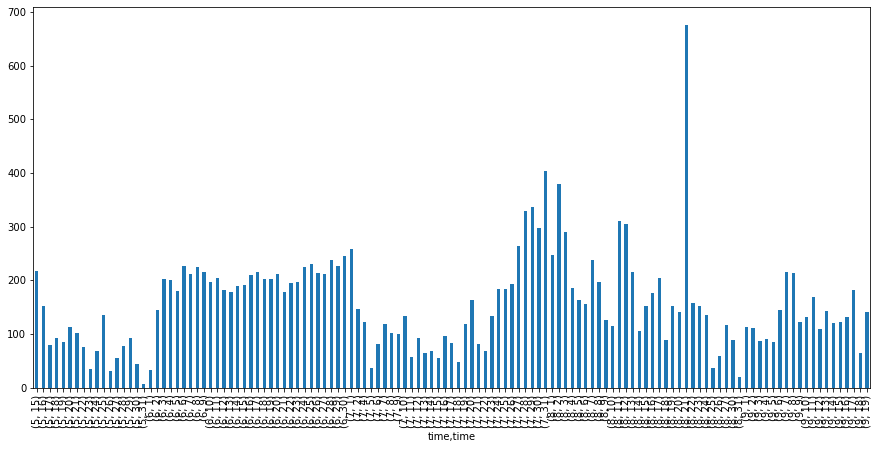

In [123]:
# Frequency of signals per day
ana.plot_freq(df)

In [125]:
features = ana.get_features(df, wf = use_wf, lpc=use_lpc, amp=use_amp)

In [134]:
# Train som
size = 12
niter = 20000 #10000
sigma = 1.23 # #0.3
learning_rate= .04 #.5
pca=False
random_seed = 1

In [ ]:
som = ana.run_som(features, size, niter = niter, sigma=sigma, learning_rate=learning_rate, 
                  pca=pca, plot_error = True, random_seed = random_seed)

0.341523454391
0.323951098282
0.314375526629
0.305626052511
0.302058402771
0.296929827289
0.291422201426
0.288521071034
0.284249806386
0.280226999808


In [135]:
import skopt
from skopt.utils import use_named_args
from skopt import gp_minimize
import math


def optimize( dimensions, initial_param, features, num_calls=12, pca = False, random_seed = 1): 

    prior_values = []
    prior_names = []
    for var in dimensions:
        name = var.name
        print( name )
        prior_names.append(name)
        prior_values.append(initial_param[name])

    global num_skopt_call
    num_skopt_call = 0
    errors = []

    @use_named_args(dimensions)
    def fitness(**p): 

        global num_skopt_call

        print('\n \t ::: {} SKOPT CALL ::: \n'.format(num_skopt_call+1))
        print(p)

        # Train som
        som = ana.run_som(features, size, niter = int(p['niter']), sigma=p['sigma'], learning_rate=p['learning_rate'], 
              pca=pca, random_seed = random_seed)
        
        q_error = som.quantization_error(features)
        t_error = som.topographic_error(features)
        errors.append((num_skopt_call, q_error, t_error))
        
        def get_score(q_error, t_error):
            
            return math.sqrt(q_error * q_error + t_error * t_error)
        
        score = get_score(q_error, t_error)
        print( q_error )
        print( t_error )
        print( score )

        num_skopt_call += 1

        return score

    search_result = gp_minimize( func = fitness, dimensions = dimensions,
                                 acq_func = 'EI', # Expected Improvement
                                 n_calls = num_calls, x0 = prior_values )

    params = pd.DataFrame(search_result['x_iters'])
    params.columns = [*prior_names]
    params = params.rename_axis('call').reset_index()
    scores = pd.DataFrame(search_result['func_vals'])
    scores.columns = ['score']
    result = pd.concat([params, scores], axis=1)
    result = result.sort_values(by=['score'])
    errors_frame = pd.DataFrame(errors, columns = ['call', 'q_error', 't_error'])
    result = pd.merge(result, errors_frame, on=['call'])   
    
    return result



In [136]:
from skopt.space import Real, Categorical, Integer

# Skopt dimensions
skopt_dims = [       
    Real(        low=1e-2, high=1,     prior='log-uniform', name='learning_rate'     ),
    Real(        low=.1,    high=5,                         name='sigma'     ),
    Real(     low=1e2,    high=1e5,   prior='log-uniform', name='niter'       )
]

# Initial parameters
init_param = {'learning_rate':0.5, 'sigma':0.3, 'niter' : 10000}

search_result = optimize(skopt_dims, init_param, features, num_calls=20, pca = pca, random_seed = random_seed)

learning_rate
sigma
niter

 	 ::: 1 SKOPT CALL ::: 

{'learning_rate': 0.5, 'sigma': 0.3, 'niter': 10000}
0.244784668252
0.882317196678
0.9156435820587024

 	 ::: 2 SKOPT CALL ::: 

{'learning_rate': 0.10640343686791102, 'sigma': 0.59357148260139703, 'niter': 16763.823000363067}
0.223880382469
0.322108567956
0.3922707677169928

 	 ::: 3 SKOPT CALL ::: 

{'learning_rate': 0.13526401057158793, 'sigma': 2.6864537065278125, 'niter': 35122.030703603901}
0.306499441813
0.0104820741341
0.3066786293662568

 	 ::: 4 SKOPT CALL ::: 

{'learning_rate': 0.076763101102767808, 'sigma': 2.5093186485307739, 'niter': 27027.713940880931}
0.306654508182
0.0114441968807
0.3068679798064233

 	 ::: 5 SKOPT CALL ::: 

{'learning_rate': 0.15789910017448264, 'sigma': 2.0290780522455667, 'niter': 388.1715714504179}
0.374917790507
0.0807676726757
0.3835189259846365

 	 ::: 6 SKOPT CALL ::: 

{'learning_rate': 0.41986799357061338, 'sigma': 2.9261958748043324, 'niter': 971.69304529601197}
0.367778164237
0.03048409

In [137]:
search_result

,call,learning_rate,sigma,niter,score,q_error,t_error
0,6,0.147972,1.039350,14770.916468,0.263167,0.248158,0.087604
1,17,0.010000,1.047845,54132.883248,0.264901,0.250050,0.087452
2,18,0.010000,0.838127,100000.000000,0.283601,0.235074,0.158649
3,14,0.053347,2.239825,14974.313967,0.301200,0.300733,0.016761
4,2,0.135264,2.686454,35122.030704,0.306679,0.306499,0.010482
5,3,0.076763,2.509319,27027.713941,0.306868,0.306655,0.011444
6,15,0.010000,2.346294,8659.417409,0.338168,0.337950,0.012153
7,9,0.179917,4.265527,14013.472884,0.360435,0.360407,0.004557
8,12,0.094995,5.000000,54521.908754,0.364590,0.364576,0.003241
9,8,0.054586,4.566050,9240.996292,0.368074,0.368074,0.000506


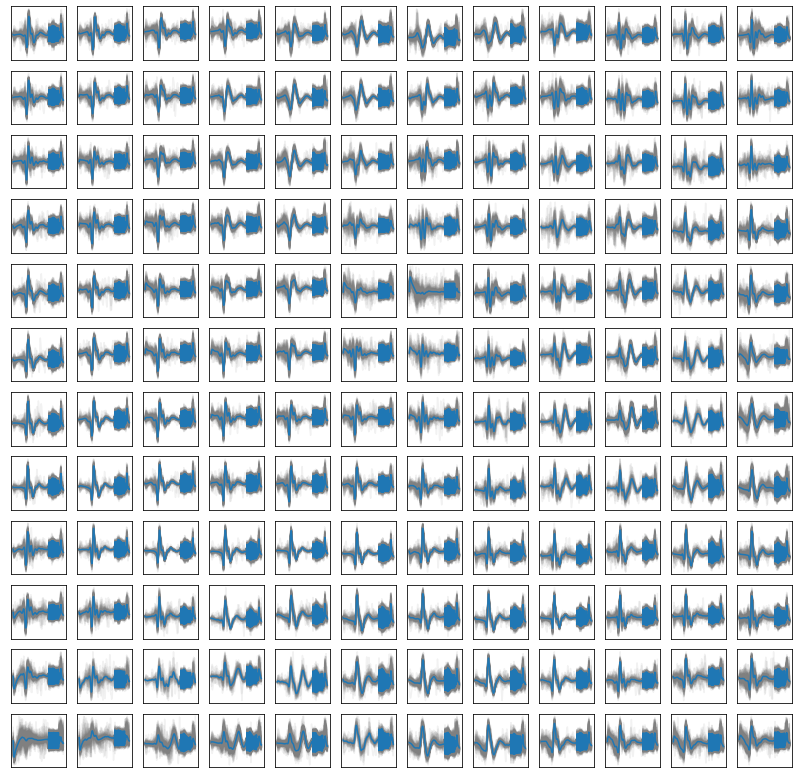

In [130]:
ana.plot_waveforms(features, som, size )

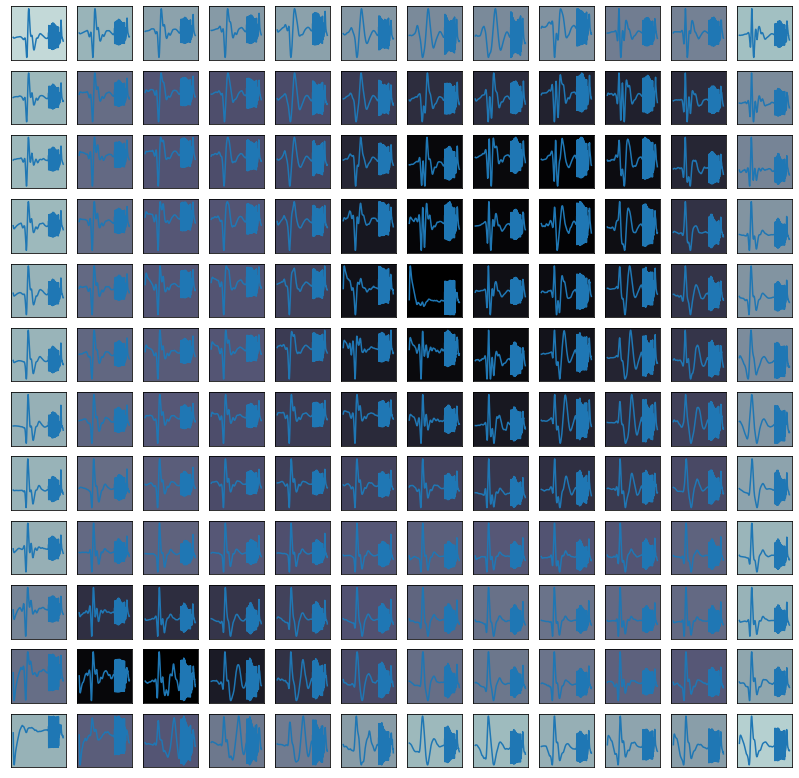

In [131]:
ana.plot_dmap(features, som, size)

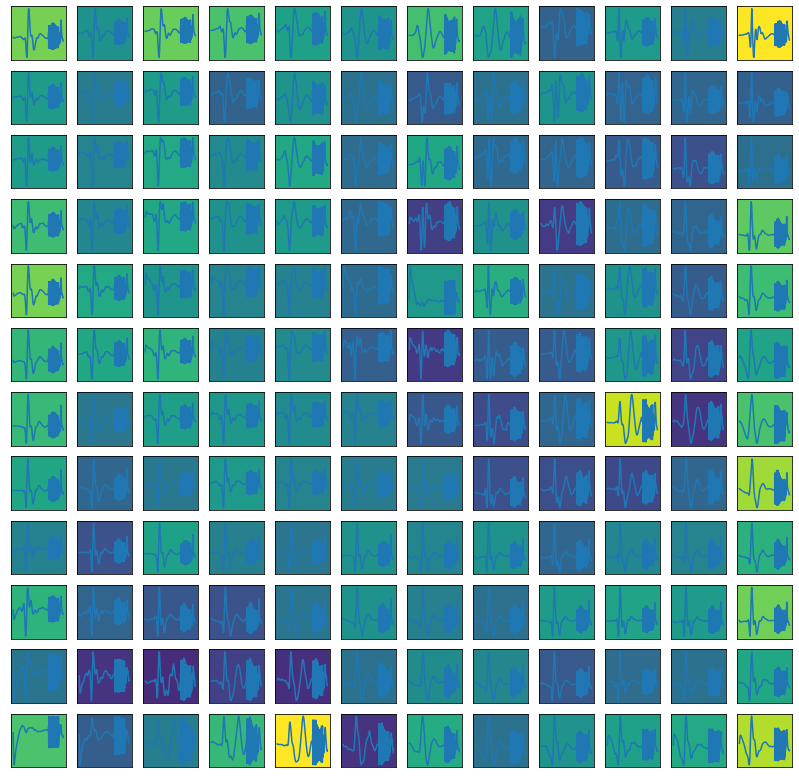

In [132]:
ana.plot_density(features, som, size )

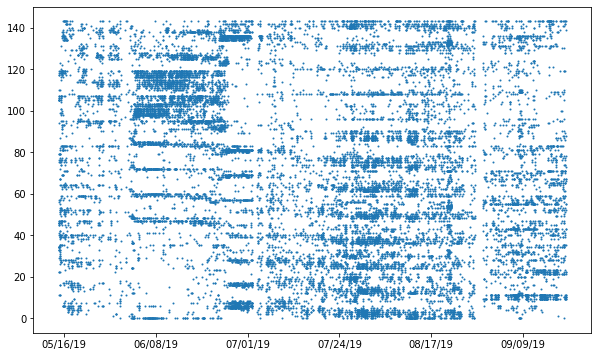

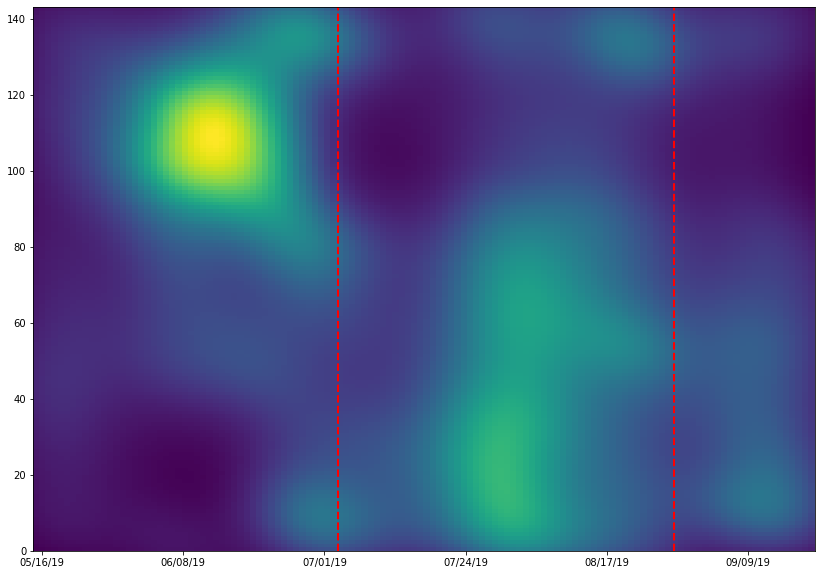

In [133]:
ana.plot_evo(df, som, size, wf = use_wf, lpc = use_lpc, amp = use_amp)